<center>
<a href="https://colab.research.google.com/drive/18uxa0ZMlck4f5fzTUdkze_cuKz-Hgx_o?usp=sharing"> <img align="center" src="https://colab.research.google.com/assets/colab-badge.svg"> </a></center>

##Installing Packages

Run this cell only if torchtext reports an error while importing bleu_score.

In [ ]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 1.1MB 4.8MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


##Importing Required Libraries

In [ ]:
from google.colab import drive
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
import spacy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


Fixing SEED for reproducibility of results

In [ ]:
SEED = 4444

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Fetching Spacy Models

In [ ]:
!python -m spacy download de
!python -m spacy download en

     |████████████████████████████████| 14.9MB 629kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=740b7d821818ed1e331c90b84077ea72455865631af7321422d13cbb4400be40
  Stored in directory: /tmp/pip-ephem-wheel-cache-2mzs3vz0/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Helper Objects and Functions

In [ ]:
de_model = spacy.load('de')
en_model = spacy.load('en')

In [ ]:
def de_tokenizer(sentence):
    return [token.text for token in de_model.tokenizer(sentence)]

def en_tokenizer(sentence):
    return [token.text for token in en_model.tokenizer(sentence)]

In [ ]:
SOURCE_Field = Field(eos_token = '<src_eos>', init_token = '<src_sos>', lower = True, include_lengths = True, tokenize = de_tokenizer)

TARGET_Field = Field(eos_token = '<trg_eos>', init_token = '<trg_sos>', lower = True, tokenize = en_tokenizer)

A helper function to return input tensor corresponding to any string or list of tokens.

In [ ]:
def ipTensor(sentence, src_field):
    if isinstance(sentence, list):
        tokens = [src_field.init_token] + [token.lower() for token in sentence] + [src_field.eos_token]
    else:
        tokens = [src_field.init_token] + de_tokenizer(sentence) + [src_field.eos_token]
    seq_len = len(tokens)
    ip_tensor = torch.LongTensor([src_field.vocab.stoi[token] for token in tokens]).to(device)
    return ip_tensor.view(seq_len, 1)

## Fetching and Splitting Data

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SOURCE_Field, TARGET_Field))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:04<00:00, 297kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 85.5kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 81.0kB/s]


In [ ]:
SOURCE_Field.build_vocab(train_data, min_freq = 2)
TARGET_Field.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Source vocab size: {len(SOURCE_Field.vocab)} | Target vocab size: {len(TARGET_Field.vocab)}")

Source vocab size: 7855 | Target vocab size: 5893


## Model Definition

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_hidden_dim, dec_hidden_dim, enc_dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(enc_dropout)
        self.rnn = nn.GRU(input_size = embedding_dim, hidden_size = enc_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(2*enc_hidden_dim, dec_hidden_dim)

    def forward(self, input, src_len):                                                      # input = [src_len, batch_size]
        embedding = self.dropout(self.embedding(input))
        packed_embedding = nn.utils.rnn.pack_padded_sequence(embedding, src_len)            # embedding = [seq_len, batch_size, embedding_dim]    
        packed_output, hidden = self.rnn(packed_embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output)                         # output = [seq_len, batch_size, enc_hidden_dim*num_directions]  hidden = [num_directions, batch_size, enc_hidden_dim]     
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))  # hidden = [batch_size, dec_hidden_dim]
        return output, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(2*enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias = False)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, enc_output, dec_hidden, mask):                                        # dec_hidden = [batch_size, dec_hidden_dim]  enc_output = [seq_len, batch_size, enc_hidden_diim*2]
        src_len = enc_output.shape[0]
        enc_output = enc_output.permute(1, 0, 2)                                            # enc_output = [batch_size, seq_len, enc_hidden_dim*2]
        dec_hidden = dec_hidden.unsqueeze(1).repeat(1, src_len, 1)                          # dec_hidden = [batch_size, seq_len, dec_hidden_dim]
        energy = torch.tanh(self.attn(torch.cat((enc_output, dec_hidden), dim = 2)))        # energy = [batch_size, seq_len, dec_hidden_dim]
        attn = self.v(energy).squeeze(2)
        attn = attn.masked_fill(mask == 0, -1e10)                                           # attn = [batch_size, seq_len]
        attn = self.softmax(attn).unsqueeze(1)                                              # attn = [batch_size, 1, seq_len]
        weighted = torch.bmm(attn, enc_output)                                              # weighted = [batch_size, 1, enc_hidden_dim*2]
        return weighted.permute(1, 0, 2), attn                                              # weighted = [1, batch_size, enc_hidden_dim*2]  attn = [batch_size, 1, seq_len]

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_hidden_dim, dec_hidden_dim, dec_dropout, attention):
        super(Decoder, self).__init__()
        self.hidden_dim = dec_hidden_dim
        self.output_dim = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dec_dropout)
        self.attn = attention
        self.rnn = nn.GRU(input_size = 2*enc_hidden_dim + embedding_dim, hidden_size = dec_hidden_dim)
        self.fc = nn.Linear(2*enc_hidden_dim + dec_hidden_dim + embedding_dim, vocab_size)

    def forward(self, input, dec_hidden, enc_output, mask):                                 # input = [1, batch_size]  dec_hidden = [batch_size, dec_hidden_dim]  enc_output = [seq_len, batch_size, enc_hidden_dim*2]
        embedding = self.dropout(self.embedding(input))                                     # embedding = [1, batch_size, embedding_dim]
        weighted, a = self.attn(enc_output, dec_hidden, mask)                               # weighted = [1, batch_size, enc_hidden_dim*2]  a = [batch_size, 1, seq_len]
        rnn_input = torch.cat((embedding, weighted), dim = 2)                               # rnn_input = [1, batch_size, embedding_dim + enc_hidden_dim*2]
        output, dec_hidden = self.rnn(rnn_input , dec_hidden.unsqueeze(0))                  # output = [1, batch_size, dec_hidden_dim]  dec_hidden = [1, batch_size, dec_hidden_dim]
        embedding = embedding.squeeze(0)                                                    # embedding = [batch_size, embedding_dim]
        output = output.squeeze(0)                                                          # output = [batch_size, dec_hidden_dim]
        weighted = weighted.squeeze(0)                                                      # weighted = [batch_size, enc_hidden_dim*2]
        fc_input = torch.cat((embedding, output, weighted), dim = 1)                        # fc_inout = [batch_size, enc_hidden_dim*2 + dec_hidden_dim + embedding_dim]  
        prediction = self.fc(fc_input)                                                      # prediction = [batch_size, vocab_Size]
        return prediction, dec_hidden.squeeze(0), a.squeeze(1)                                 

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
    
    def create_mask(self, source):
        mask = (source != self.src_pad_idx).permute(1, 0)
        return mask
    
    def forward(self, source, target, src_len, teacher_forcing_ratio):                   # source = [seq_len, batch_size]  target = [seq_len, batch_size]                                               
        src_batch_size = source.shape[1]
        enc_output, enc_hidden = self.encoder(source, src_len)                           
        dec_hidden = enc_hidden
        seq_len = target.shape[0]
        batch_size = target.shape[1]
        predictions = torch.zeros(seq_len, batch_size, self.decoder.output_dim).to(device)
        input = target[0,:].unsqueeze(0)
        mask = self.create_mask(source)
        for t in range(1, seq_len):
            prediction, dec_hidden, a = self.decoder(input, dec_hidden, enc_output, mask)
            predictions[t] = prediction.view(batch_size, self.decoder.output_dim)
            if random.random() < teacher_forcing_ratio:
                input = target[t].unsqueeze(0)
            else:
                input = prediction.argmax(1).unsqueeze(0)
        return predictions[1:]

## Training and Evaluation Functions

In [ ]:
def Train(iterator, model, criterion, optimizer, clip=1):
    model.train()
    epoch_loss = 0
    for _, batch in enumerate(iterator):
        model.zero_grad()
        source, src_len = batch.src
        target = batch.trg
        outputs = model(source, target, src_len, teacher_forcing_ratio=1)
        outputs = outputs.view(-1, outputs.shape[-1])
        targets = target[1:].view(-1)
        batch_loss = criterion(outputs, targets.to(device))
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += batch_loss.item()

    return epoch_loss/len(iterator)

In [ ]:
def Evaluate(iterator, model, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            source, src_len = batch.src
            target = batch.trg
            outputs = model(source, target, src_len, 0)
            outputs = outputs.view(-1, outputs.shape[-1])
            targets = target[1:].view(-1)
            batch_loss = criterion(outputs, targets.to(device))
            eval_loss += batch_loss.item()
        
        return eval_loss/len(iterator)

In [ ]:
def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return (elapsed_mins, elapsed_secs)

## Data Iterators, Hyperparameters and Model Initialization

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, sort_within_batch = True, sort_key = lambda x : len(x.src), device = device)

In [ ]:
print("Number of Training sequences: ", len(train_data.examples))
print("Number of Test sequences: ", len(test_data.examples))
print("Number of Validation sequences: ", len(valid_data.examples))

Number of Training sequences:  29000
Number of Test sequences:  1000
Number of Validation sequences:  1014


In [ ]:
CLIP = 1
NUM_EPOCHS = 20
LR = 0.001
HIDDEN_DIM = 512
SRC_VOCAB_SIZE = len(SOURCE_Field.vocab)
TRG_VOCAB_SIZE = len(TARGET_Field.vocab)
EMBEDDING_DIM = 256
NUM_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [ ]:
target_padding_index = TARGET_Field.vocab.stoi[TARGET_Field.pad_token]
source_padding_index = SOURCE_Field.vocab.stoi[SOURCE_Field.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = target_padding_index)

In [ ]:
attention = Attention(HIDDEN_DIM, HIDDEN_DIM)
encoder = Encoder(SRC_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM, ENC_DROPOUT).to(device)
decoder = Decoder(TRG_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM, DEC_DROPOUT, attention).to(device)
seq2seq = Seq2Seq(encoder, decoder, source_padding_index).to(device)
optimizer = optim.AdamW(seq2seq.parameters(), LR)

In [ ]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [ ]:
seq2seq.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (attn): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
      (softmax): Softmax(dim=1)
    )
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=5893, bias=True)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters.')

The model has 20,518,917 trainable parameters.


## Download Pre-Trained Model
Run this section instead of the "Training" section if you wish to download the pre-trained model instead of training one yourself.

In [ ]:
# !wget -O Seq2Seq_with_Attention.pth https://gitlab.com/rishika2110/weights/-/blob/6e88f0c7acaf5d86d803eca8abb150e0b79f95ef/neural_machine_translation/Seq2Seq_with_Attention.pth

In [ ]:
# MODEL_STORE_PATH = "Seq2Seq_with_Attention.pth"

## Training
Run this section only if you want to train the model yourself and store the trained weights in G-Drive.

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
MODEL_STORE_PATH = '/content/gdrive/My Drive/Colab/NLP/Machine Translation/Models/Seq2Seq_with_Attention.pth'

In [ ]:
print(f"Learning Rate: {LR}, Hidden Dimensions: {HIDDEN_DIM}")
train_losses = []
valid_losses = []
prev_epoch = 1
min_losses = [float('inf'), float('inf')]
start_time = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = Train(train_iterator, seq2seq, criterion, optimizer, CLIP)
    train_losses.append(train_loss)
    valid_loss = Evaluate(test_iterator, seq2seq, criterion)
    valid_losses.append(valid_loss)
    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss
        torch.save(seq2seq.state_dict(), MODEL_STORE_PATH)
    if epoch % int(NUM_EPOCHS / 10) == 0:
        elapsed_time = Epoch_time(start_time, time.time())
        print(f"Time taken for epochs {prev_epoch} to {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
        start_time = time.time()
        prev_epoch = epoch + 1
        print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
        print(f"Training PPL: {math.exp(train_loss):.4f} | Validation PPL: {math.exp(valid_loss):.4f}")
print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.001, Hidden Dimensions: 512
Time taken for epochs 1 to 2: 3m 12s
Training Loss: 3.4056 | Validation Loss: 5.7388
Training PPL: 30.1336 | Validation PPL: 310.6764
Time taken for epochs 3 to 4: 3m 7s
Training Loss: 2.0510 | Validation Loss: 4.9456
Training PPL: 7.7755 | Validation PPL: 140.5516
Time taken for epochs 5 to 6: 3m 7s
Training Loss: 1.3983 | Validation Loss: 4.9608
Training PPL: 4.0481 | Validation PPL: 142.7125
Time taken for epochs 7 to 8: 3m 7s
Training Loss: 1.0136 | Validation Loss: 5.1214
Training PPL: 2.7555 | Validation PPL: 167.5718
Time taken for epochs 9 to 10: 3m 7s
Training Loss: 0.7655 | Validation Loss: 5.3346
Training PPL: 2.1500 | Validation PPL: 207.3938
Time taken for epochs 11 to 12: 3m 7s
Training Loss: 0.5960 | Validation Loss: 5.7328
Training PPL: 1.8148 | Validation PPL: 308.8211
Time taken for epochs 13 to 14: 3m 7s
Training Loss: 0.4692 | Validation Loss: 5.9265
Training PPL: 1.5988 | Validation PPL: 374.8340
Time taken for epochs 15

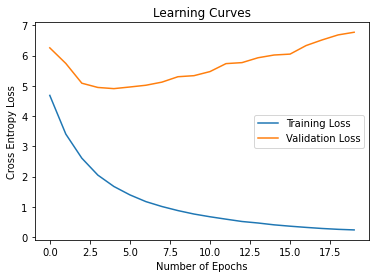

In [ ]:
plt.title('Learning Curves')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.plot(train_losses, label = 'Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab/NLP/Machine Translation/Plots/Seq2Seq_with_Attention.jpeg')
plt.show()

## Sampling

Run the cell below to load the model for sampling.

In [ ]:
seq2seq.load_state_dict(torch.load(MODEL_STORE_PATH))

<All keys matched successfully>

In [ ]:
seq2seq.eval()
test_loss = Evaluate(test_iterator, seq2seq, criterion)
print(f"Test Loss: {test_loss:.4f} | Test PPL: {math.exp(test_loss):.4f}")

Test Loss: 4.9067 | Test PPL: 135.1867


In [ ]:
def Translate(src_sentence, src_field, trg_field, model):
    ip_tensor = ipTensor(src_sentence, src_field)
    max_len = 4*ip_tensor.shape[0]
    src_len = [ip_tensor.shape[0]]
    with torch.no_grad():
        enc_output, enc_hidden = model.encoder(ip_tensor, src_len)
    dec_hidden = enc_hidden
    sos_id = trg_field.vocab.stoi[trg_field.init_token]
    eos_id = trg_field.vocab.stoi[trg_field.eos_token]
    predicts = [sos_id]
    len = 1
    attentions = torch.zeros((1, ip_tensor.shape[0])).to(device)
    src_mask = model.create_mask(ip_tensor)
    while len < max_len:
        input = torch.LongTensor([predicts[-1]]).view((1, 1)).to(device)
        with torch.no_grad():
            output, dec_hidden, a = model.decoder(input, dec_hidden, enc_output, src_mask)
        attentions = torch.cat((attentions, a), dim = 0)
        predicts.append(output.argmax(1).item())
        len += 1
        if predicts[-1] == eos_id:
            break
    sentence = [trg_field.vocab.itos[id] for id in predicts[1:]]
    return sentence, attentions[1:]

In [ ]:
ind = int(random.random()*len(test_data.examples))
example = test_data.examples[ind]
src_sentence = example.src
trg_sentence = example.trg
print("German Sentence: ", ' '.join(src_sentence))
translation, attention = Translate(src_sentence , SOURCE_Field, TARGET_Field, seq2seq)
print("Predicted Translation: ", ' '.join(translation[:-1]))
print("Actual Translation: ", ' '.join(trg_sentence))

German Sentence:  ein junge fährt skateboard auf einer skateboardrampe .
Predicted Translation:  a boy is skateboarding on a skateboard ramp .
Actual Translation:  a boy riding a skateboard on a skateboarding ramp


## Display Attention

In [ ]:
def Disp_Attn(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    attention = attention.squeeze(0).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
    ax.set_yticklabels(['']+translation)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

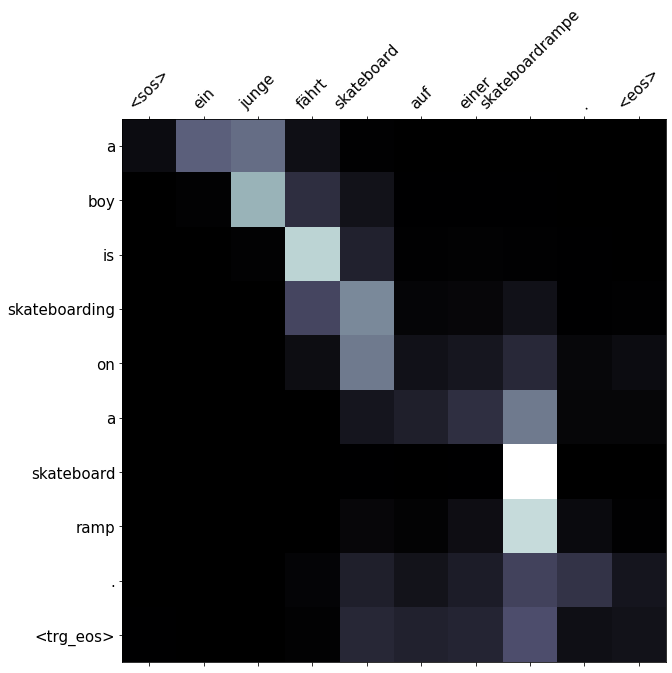

In [ ]:
Disp_Attn(src_sentence, translation, attention)

## BLEU Score

In [ ]:
def Calculate_BLEU(data, src_field, trg_field, model):
    trgs = []
    predicted_trgs = []
    for i in range(len(data.examples)):
        src_sentence = vars(data[i])['src']
        trg_sentence = vars(data[i])['trg']
        try:                                # Sometimes(rarely) CUDA throws a "Device side assert triggered" error. So, just to avoid restarting runtime.
            predicted_trg, _ = Translate(src_sentence, src_field, trg_field, model)
            predicted_trgs.append(predicted_trg[:-1])
            trgs.append([trg_sentence])
        except:
            pass
    return bleu_score(predicted_trgs, trgs)

In [ ]:
bleu_score_test = Calculate_BLEU(test_data, SOURCE_Field, TARGET_Field, seq2seq)
print(f"BLEU score on Testing Data: {bleu_score_test*100:.2f}")

BLEU score on Testing Data: 31.24
